In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
# read in data
data_file = "../data/full_opt_15KeV/dataset_0.json"

with open(data_file) as f:
    data = json.load(f)["samples"]
    
total_df = pd.DataFrame.from_dict(data, orient="index")
x_df = pd.DataFrame.from_records(total_df['dvar'].values)
y_df = pd.DataFrame.from_records(total_df['obj'].values)

# convert to numeric types
for col in x_df.columns:
    x_df[col] = pd.to_numeric(x_df[col])
    
for col in y_df.columns:
    y_df[col] = pd.to_numeric(y_df[col])

In [4]:
x_dim = x_df.shape[1]; y_dim = y_df.shape[1]
x_ranges = {col: {'min': x_df[col].values.min(), 'max': x_df[col].values.max()} for col in x_df.columns}
y_ranges = {col: {'min': y_df[col].values.min(), 'max': y_df[col].values.max()} for col in y_df.columns}

In [5]:
# scaling
scaler = MinMaxScaler(feature_range=(-1., 1.))
eps = 1e-7

for col in x_df.columns:
    x_df[col] = scaler.fit_transform(x_df[col].values.reshape(-1, 1))
    
for col in y_df.columns:
    y_df[col] = scaler.fit_transform(y_df[col].values.reshape(-1, 1))
    
assert(all([abs(1 - x_df[col].max()) < eps for col in x_df.columns]))
assert(all([abs(-1 - x_df[col].min()) < eps for col in x_df.columns]))
assert(all([abs(1 - y_df[col].max()) < eps for col in y_df.columns]))
assert(all([abs(-1 - y_df[col].min())< eps for col in y_df.columns]))

In [6]:
# split train and test sets
train_file = "../indexes/train_indexes.csv"; test_file = "../indexes/test_indexes.csv"
train_indexes = pd.read_csv(train_file).values.T[0]; test_indexes = pd.read_csv(test_file).values.T[0]

x_train_df = x_df.loc[train_indexes]; x_test_df = x_df.loc[test_indexes];
y_train_df = y_df.loc[train_indexes]; y_test_df = y_df.loc[test_indexes]

x_train = x_train_df.values.astype("float32")
x_test = x_test_df.values.astype("float32")
y_train = y_train_df.values.astype("float32")
y_test = y_test_df.values.astype("float32")

In [7]:
# building the model
depth = 5
width = 100
activation = "sigmoid"

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(x_dim,)))
for i in range(depth + 1): # the depth + 1 is so that it matches the Julia formulation
    model.add(layers.Dense(width, activation=activation))
model.add(layers.Dense(y_dim))

2022-11-30 15:20:11.766235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# specify configs for training
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.MeanSquaredError()

model.compile(
    optimizer=optimizer,
    loss=loss,
)

In [9]:
# configs for recording timing information
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [10]:
# training
epochs = 2500
batch_size = 1024

time_callback = TimeHistory()
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[time_callback]
)

training_times = time_callback.times

Epoch 1/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0993
Epoch 2/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0654
Epoch 3/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0363
Epoch 4/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0201
Epoch 5/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0124
Epoch 6/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0109
Epoch 7/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0103
Epoch 8/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0100
Epoch 9/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 10/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0096
Epoch 11/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0095
Epoch 12/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0094
E

170/170 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 99/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 100/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 101/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 102/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 103/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 104/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 105/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 106/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 107/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 108/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 109/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0

170/170 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 195/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 196/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 197/2500
170/170 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 198/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 199/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 200/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 201/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 202/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 203/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 204/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 205/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 291/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 292/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 293/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 294/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 295/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 296/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 297/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 298/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 299/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 300/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 301/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 387/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 388/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 389/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 390/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 391/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 392/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 393/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 394/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 395/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 396/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 397/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 483/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 484/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 485/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 486/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 487/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 488/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 489/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 490/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 491/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 492/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 493/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 579/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 580/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 581/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 582/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 583/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 584/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 585/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 586/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 587/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 588/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 589/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 675/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 676/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 677/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 678/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 679/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 680/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 681/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 682/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 683/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 684/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 685/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 771/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 772/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 773/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 774/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 775/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 776/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 777/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 778/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 779/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 780/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 781/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 867/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 868/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 869/2500
170/170 [==============================] - 1s 6ms/step - loss: 0.0048
Epoch 870/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 871/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 872/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 873/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 874/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 875/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 876/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 877/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 963/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 964/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 965/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 966/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 967/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 968/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 969/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 970/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 971/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 972/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 973/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.

170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1058/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1059/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1060/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1061/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1062/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1063/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 1064/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 1065/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1066/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1067/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1068/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1153/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1154/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1155/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1156/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1157/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1158/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1159/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 1160/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1161/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1162/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 1163/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1248/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1249/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1250/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1251/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1252/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1253/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1254/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1255/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1256/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1257/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1258/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1343/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1344/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1345/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1346/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1347/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1348/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1349/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1350/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1351/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1352/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1353/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1438/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1439/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1440/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1441/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1442/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1443/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1444/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1445/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1446/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0046
Epoch 1447/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1448/2500
170/170 [==============================] - 1s 5ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1533/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1534/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1535/2500
170/170 [==============================] - 1s 6ms/step - loss: 0.0045
Epoch 1536/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0045
Epoch 1537/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0045
Epoch 1538/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1539/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1540/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0045
Epoch 1541/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1542/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1543/2500
170/170 [==============================] - 1s 5ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1628/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1629/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1630/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1631/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1632/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1633/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1634/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1635/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1636/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1637/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 1638/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1723/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1724/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1725/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1726/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1727/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1728/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1729/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1730/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1731/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1732/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1733/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1818/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1819/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1820/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1821/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1822/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1823/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1824/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1825/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1826/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1827/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1828/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1913/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1914/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1915/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1916/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 1917/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 1918/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1919/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 1920/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 1921/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1922/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 1923/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2008/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2009/2500
170/170 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 2010/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0043
Epoch 2011/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2012/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2013/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2014/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2015/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2016/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2017/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2018/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2103/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2104/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2105/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2106/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2107/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2108/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2109/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2110/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2111/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2112/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2113/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2198/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2199/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2200/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2201/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2202/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2203/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2204/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2205/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2206/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2207/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2208/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2293/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2294/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2295/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2296/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2297/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2298/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2299/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2300/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2301/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2302/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 2303/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2388/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2389/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2390/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2391/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2392/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2393/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2394/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2395/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2396/2500
170/170 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 2397/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2398/2500
170/170 [==============================] - 1s 4ms/step

170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2483/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2484/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2485/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2486/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2487/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2488/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2489/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2490/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2491/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2492/2500
170/170 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 2493/2500
170/170 [==============================] - 1s 5ms/step

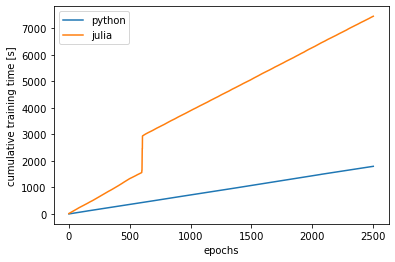

In [38]:
# compare training times
training_times_python = np.array(training_times)
training_times_julia = pd.read_csv('../results/timing_results/julia_cpu_d5_w100.csv').values

plt.plot(np.arange(1, 2501), training_times_python.cumsum(), label='python')
plt.plot(np.arange(1, 2501), training_times_julia.cumsum(), label='julia')
plt.xlabel('epochs')
plt.ylabel('cumulative training time [s]')
plt.legend()
plt.show()

In [26]:
y_train_scaled_df = pd.DataFrame(y_train, columns=y_df.columns)
y_test_scaled_df = pd.DataFrame(y_test, columns=y_df.columns)

y_train_preds_scaled_df = pd.DataFrame(model.predict(x_train), columns=y_df.columns)
y_test_preds_scaled_df = pd.DataFrame(model.predict(x_test), columns=y_df.columns)

1354/1354 [==============================] - 1s 452us/step


In [32]:
def unscale_df(df, ranges):
    unscaled_df = df.copy()
    for col in df.columns:
        scaler = MinMaxScaler(feature_range=(ranges[col]['min'], ranges[col]['max']))
        unscaled_df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
    return unscaled_df

y_train_unscaled_df = unscale_df(y_train_scaled_df, y_ranges)
y_test_unscaled_df = unscale_df(y_test_scaled_df, y_ranges)

y_train_preds_unscaled_df = unscale_df(y_train_preds_scaled_df, y_ranges)
y_test_preds_unscaled_df = unscale_df(y_test_preds_scaled_df, y_ranges)

In [35]:
from sklearn.metrics import mean_absolute_percentage_error

for col in y_df.columns:
    print(col)
    print(
        "train set mape:",
        mean_absolute_percentage_error(y_train_unscaled_df[col].values, y_train_preds_unscaled_df[col].values)
    )
    print(
        "test set mape:",
        mean_absolute_percentage_error(y_test_unscaled_df[col].values, y_test_preds_unscaled_df[col].values)
    )
    print('---')

OBJ1
train set mape: 0.01904929
test set mape: 0.01875673
---
OBJ2
train set mape: 0.020310225
test set mape: 0.022526553
---
OBJ3
train set mape: 0.21098992
test set mape: 0.42158538
---
OBJ4
train set mape: 4.036763
test set mape: 3.4050267
---
OBJ5
train set mape: 0.107359014
test set mape: 0.27483088
---
OBJ6
train set mape: 0.107611656
test set mape: 0.15348667
---
